# Levy Flight Background and Visualization

In [1]:
from dataclasses import dataclass
from functools import partial
from time import time

from matplotlib.axes import Axes
from matplotlib.collections import PathCollection
from matplotlib.lines import Line2D
from matplotlib.pyplot import Figure, subplots, style
from numpy import arange, array, cumsum, exp, float64, linspace, imag, int64, ndarray, pi, real, sqrt, zeros
from numpy.random import Generator, SeedSequence, default_rng

import ipywidgets as widgets
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#%config InlineBackend.figure_format = 'svg'
%matplotlib widget

style.use("ggplot")

current_time = int(time())

# The global pseudo-random number generator.
rng = default_rng(SeedSequence(current_time))

Path = ndarray[float64 | int64]
"""A type representing a random path."""

@dataclass
class PlotContext:
    """
    Maintains all information about a single Matplotlib figure.

    This allows figures to be updated quickly wihtout re-rendering the entire canvas.
    """

    fig: Figure
    """The Matplotlib figure."""

    ax: Axes
    """The drawing utility for rendering all axis-specific items."""

    path: Line2D
    """The current random path."""

    origin: PathCollection
    """The origin location (always (0, 0))."""

    def update_path(self, X: Path, Y: Path, xlabel: str, ylabel: str):
        """
        Updates this context's random path.

        :param X: The new x-axis values.
        :param Y: The new y-axis values.
        :param xlabel: The new x-axis label.
        :param ylabel: The new y-axis label.
        """
        self.ax.set_xlim(self.compute_new_limits(X))
        self.ax.set_ylim(self.compute_new_limits(Y))
        self.path.set_data(X, Y)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)

    def compute_new_limits(self, X: Path) -> tuple[float, float]:
        """
        Creates new numeric limits around a set of data.

        This function mirrors the default Matplotlib behavior by including a 5% padding.

        :param X: The new x-axis values.
        :return: A tuple containing new minimum and maximum limits.
        """
        min_val, max_val = X.min(), X.max()

        return (0.05 * min_val + min_val), (0.05 * max_val + max_val)


def create_plot_context(name: str, title: str, X0: Path, Y0: Path, path_color: str, origin_color: str):
    """
    Creates a new Matplotlib figure with an initial set of data.

    :param name: The unique internal name to use as a reference.
    :param title: The figure title.
    :param X0: The initial x-axis values.
    :param Y0: The initial y-axis values.
    :param path_color: The color of the (X, Y) path line.
    :param origin_color: The color of the origin (0, 0) point.
    :return: A new plot context.
    """
    fig, ax = plt.subplots(num=name, layout="constrained")
    path, = ax.plot(X0, Y0, color=path_color)
    origin = ax.scatter(0, 0, s=55, color=origin_color, marker="*", zorder=3)
    ax.set_xlabel("x-motion")
    ax.set_ylabel("y-motion")
    ax.set_title(title)

    return PlotContext(fig, ax, path, origin)

## Random Walks

The concept of a *random walk* is quite simple.  Given an object - a point, an agent, or a gas molecule, to name just a few examples - we determine a random path by flipping a coin for each step along every axis of direction we would like to move.  If the coin toss is heads then we move forward along the axis, otherwise we go backwards.

As you might imagine, this is a discrete stochastic process.  Mathematically, we can say that for each axis we perform a single draw from a Bernoulli distribution $X \sim\sim \text{Bernoulli}(p = 0.5)$ such that the direction at some time step $d_{t}$ is:

\begin{equation}
d_{t} = 
    \begin{cases}
        +1, & \text{if} X = 1 \\
        -1, & \text{if} X = 0 \\
    \end{cases}
\end{equation}

and our total trajectory at time $t$ is equivalent to the cumulative summation of the series $\{d_0, d_1, d_2, ...., d_t\}$.  The above implementation yields a *symmetric random walk* as at any time $t$ because $E[d_t] = 0$.  This property is why $E[d_t^{2}]$ is more statistically useful.

The colloquial name for a random walk is a *drunkard's walk* due to the assumed lack of bias for any particular direction.

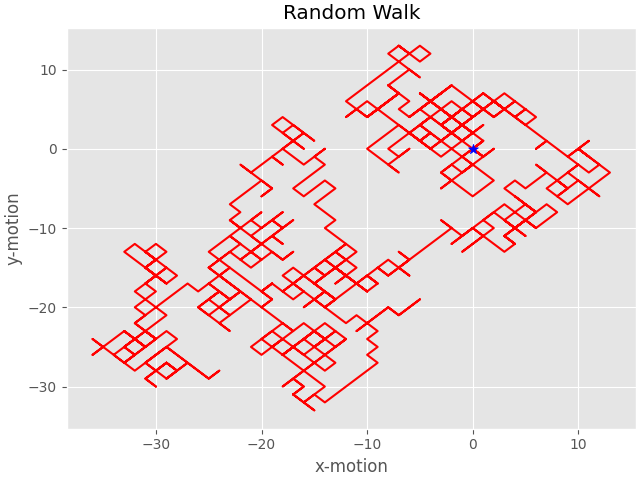

interactive(children=(IntSlider(value=1000, description='steps', max=10000, min=500, step=100), SelectionSlide…

<function __main__.visualize_walk(steps: int, dims: str)>

In [2]:
def random_walk(steps: int) -> Path:
    """
    Creates a new random path over a particular number of steps, or iterations.

    :param steps: The number of path choices to make.
    :return: A new random path.
    """
    dirs = rng.random(steps, dtype=np.float64)
    coords = zeros(steps, dtype=np.int64)

    coords[dirs >= 0.5] = 1
    coords[dirs < 0.5] = -1
    
    return cumsum(coords)


def visualize_walk(steps: int, dims: str):
    """
    Updates the random walk plot with new data.

    :param steps: The number of path choices to make.
    :param dims: Which dimension to use (1D or 2D).
    """
    match dims:
        case "1D":
            X = random_walk(steps)
            t = arange(steps)
            walk_ctx.update_path(t, X, "t-time", "x-motion")
        case "2D":
            X, Y = random_walk(steps), random_walk(steps)
            walk_ctx.update_path(X, Y, "x-motion", "y-motion")


walk_ctx = create_plot_context(
    name="random-walk",
    title="Random Walk",
    X0=random_walk(1000), 
    Y0=random_walk(1000),
    path_color="red",
    origin_color="blue"
)

steps = widgets.IntSlider(min=500, max=10000, step=100, value=1000)
dims = widgets.SelectionSlider(
    options=['1D', '2D'],
    value='2D',
    description='dims',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
plt.show()

widgets.interact(visualize_walk, steps = steps, dims = dims)


## Brownian Motion

*Brownian motion* is named after scientist Robert Brown (1773-1858) who is credited with first observing the motion of small grains in a suspended liquid under his microscope and then postulating that such a phenonemon could only occur due to the actions of tiny animals (animalcules)<sup>[2]</sup>.  Humorous anecdotes aside, Brownian motion is typically conceptualized as the limit of a random walk where the step size decreases and the "speed" increases.  Unlike the random walk in the previous section, Brownian motion is continuous.

There are many different formulas one may use to compute Brownian motion.  The visualization below uses the following:

\begin{align}
X(0) &= x_0 \\
X(t + dt) &= X(t) + N(0, \delta^{2}dt; t, t + dt)
\end{align}
where $N$ is a normal distribution function with mean $0$, variance $\delta^{2}dt$ and each invocation is independently drawn from distinct time intervals $t, t + dt$.

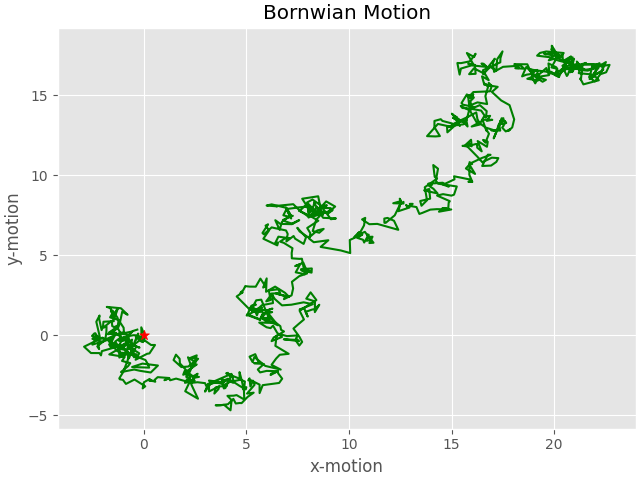

interactive(children=(IntSlider(value=1000, description='steps', max=10000, min=500, step=100), SelectionSlide…

<function __main__.visualize_motion(steps: int, dims: str, delta: float, dt: float)>

In [7]:
def brownian_motion(delta: float, steps: int, dt: float = 1.0) -> Path:
    """
    Computes a new random walk using Brownian motion.

    :param delta: The "speed" of the motion.
    :param steps: The number of path choices to make.
    :param dt: The time step.
    :return: A  new Brownian path.
    """
    return np.cumsum(rng.normal(loc=0, size=steps, scale=delta * sqrt(dt)))


def visualize_motion(steps: int, dims: str, delta: float, dt: float):
    """
    Updates the Brownian motion plot with new data.

    :param steps: The number of path choices to make.
    :param dims: Which dimension to use (1D or 2D).
    ;param delta:  The "speed" of the motion.
    :param dt: The time step.
    """
    match dims:
        case "1D":
            X = brownian_motion(delta, steps, dt)
            t = arange(X.shape[0])
            brownian_ctx.update_path(t, X, "t-time", "x-motion")
        case "2D":
            X, Y = brownian_motion(delta, steps, dt), brownian_motion(delta, steps, dt)
            brownian_ctx.update_path(X, Y, "x-motion", "y-motion")

brownian_ctx = create_plot_context(
    name="brownian-motion",
    title="Bornwian Motion",
    X0=brownian_motion(1.0, 1000, 0.1), 
    Y0=brownian_motion(1.0, 1000, 0.1),
    path_color="green",
    origin_color="red"
)

steps = widgets.IntSlider(min=500, max=10000, step=100, value=1000)
dims = widgets.SelectionSlider(
    options=['1D', '2D'],
    value='2D',
    description='dims',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
delta = widgets.FloatSlider(min=0.1, max=3.0, value=1.0)
dt = widgets.FloatSlider(min=0.1, max=10.0)

plt.show()
widgets.interact(visualize_motion, steps = steps, dims = dims, delta = delta, dt = dt)

## Levy Flights

Leveraged in a wide variety of applications, Levy flights use a long-tailed distribution for the step size that allows them to create "jumps" between different locations.

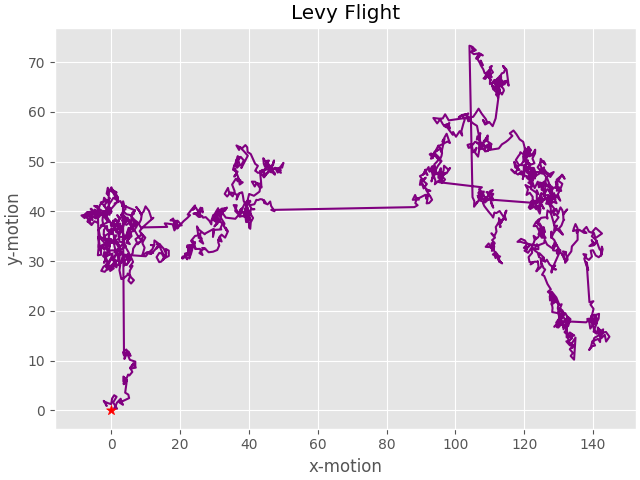

interactive(children=(IntSlider(value=1000, description='steps', max=10000, min=500, step=100), SelectionSlide…

<function __main__.visualize_levy(steps: int, dims: str, distribution: str)>

In [4]:
def from_polar(r: ndarray[float64], theta: ndarray[float64]) -> ndarray[float64]:
    """
    Converts a series of points in polar coordinates to 2D Cartesian space.

    :param r: The polar length.
    :param theta: The polar angle.
    :return: A collection of points in 2D Cartesian space.
    """
    z = r * exp ( 1j * theta )
    x_coord = real ( z )
    y_coord = imag ( z )
    return array ([ x_coord , y_coord ])

def levy_flight(steps: int, distribution: str):
    """
    Creates a new Levy flight over a particular number of steps, or iterations.

    :param steps: The number of path choices to make.
    :param distribution: The type of distribution to use.
    :return: A new Levy flight.
    """
    t = linspace(0.51, 50, 10 * steps)
    
    match distribution:
        case "Smirnov":
            s = (1/ sqrt (2* pi ))*( t -0.5)**( -3/2)*(exp ( -1/(2*( t -0.5))))
        case "Cauchy":
            s = (1/ np.pi )*(1/(0.01+( t -1)**2))
        case "Gaussian":
            s = (1/ sqrt (2* pi ))*( exp ((( t -1)**2)/ -2))

    step_sizes = rng.choice(t , size=steps , p=(s / s . sum ()))
    directions = rng .uniform( low=0 , high=2 *  pi , size=steps)

    return np.cumsum(from_polar(step_sizes, directions))

def visualize_levy(steps: int, dims: str, distribution: str):
    """
    Updates the Levy flight plot with new data.

    :param steps: The number of path choices to make.
    :param dims: Which dimension to use (1D or 2D).
    :param distribution: Which stable Levy distribution to use.
    """
    match dims:
        case "1D":
            X = levy_flight(steps, distribution)
            t = np.arange(X.shape[0])
            levy_ctx.update_path(t, X, "t-time", "x-motion")
        case "2D":
            X, Y = levy_flight(steps, distribution), levy_flight(steps, distribution)
            levy_ctx.update_path(X, Y, "x-motion", "y-motion")


levy_ctx = create_plot_context(
    name="levy-flight",
    title="Levy Flight",
    X0 = levy_flight(1000, "Cauchy"), 
    Y0=levy_flight(1000, "Cauchy"),
    path_color="purple",
    origin_color="red"
)

steps = widgets.IntSlider(min=500, max=10000, step=100, value=1000)
dims = widgets.SelectionSlider(
    options=['1D', '2D'],
    value='2D',
    description='dims',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
distribution = widgets.ToggleButtons(
    options=['Cauchy', 'Gaussian', 'Smirnov'],
    description='distribution:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

plt.show()
widgets.interact(visualize_levy, steps = steps, dims = dims, distribution = distribution)

## References

1. Hill, Alexander (2020) Random Walks : The Properties, Applications and Methods of Analysis. Bachelor's Thesis, Mathematics
2. Haw, M.D. (2002). Colloidal suspensions, Brownian motion, molecular
reality: a short history. *J OURNAL OF P HYSICS: CONDENSED MATTER*, 14.
3. 